# LDA Topic Modeling and Clustering

Use the LDA model to create topics, or clusters, present in the dataset using the abstracts of the papers. Each topic corresponds to a set of word-probability pairs, and I chose to use the top 15 highest probability words of each topic to represent the given topic. Each paper is assigned a topic based on how many of the top 15 words of each topic are included in the abstract, and how often.

In [1]:
# download gensim and wordcloud libraries with
# pip install --upgrade gensim
# pip install wordcloud

In [2]:
import numpy as np
import pandas as pd
import json
import itertools
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import nltk
from nltk.stem.snowball import SnowballStemmer
#from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords 
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize 
#nltk.download('punkt')
from nltk.stem import WordNetLemmatizer 
#nltk.download('wordnet')

import re

import gensim
from gensim import corpora, models

/Users/jayfeng/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Read in abstracts.csv and filters out rows with missing values

In [3]:
df = pd.read_csv("abstracts.csv")
df = df[df["abstract"] != "NaN"]
df = df.dropna()

Set up stop words, stemmer, and lemmatizer

In [4]:
stop_words = set(stopwords.words('english')) 
snowBallStemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

Tokenize and clean the abstracts of every paper

In [5]:
def tokenize_clean(abstract):
    #tokenizes abstract string
    tokens = word_tokenize(abstract.lower())
    
    #lemmatizes tokens
    counter = 0
    while counter < len(tokens):
        tokens[counter] = lemmatizer.lemmatize(tokens[counter])
        counter += 1
    
    #filters, stems, and lowercases tokens
    filtered_tokens = []
    for i in tokens:
        if i not in stop_words and len(i) > 3 and i != "abstract":
            stemmed_word = snowBallStemmer.stem(i)
            filtered_tokens.append(stemmed_word)
    
    return filtered_tokens

df["abstract tokens"] = df.apply(lambda row: tokenize_clean(row.abstract), axis=1)

Perform LDA topic modelling on a sample of the papers for time/speed purposes.

In [6]:
partial_df = df.sample(10000)

Create a list of lists of cleaned tokens of abstracts

In [7]:
partial_texts = []
for index, row in partial_df.iterrows():
    partial_texts.append(row[3])

Use Gensim library to perform LDA topic modelling

In [8]:
dictionary = corpora.Dictionary(partial_texts)
dictionary.filter_extremes(no_below=3)

corpus = [dictionary.doc2bow(text) for text in partial_texts]

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=50)

In [9]:
lda_results = ldamodel.show_topics(num_topics=10, num_words=20, formatted=False)
lda_results

[(0,
  [('virus', 0.036254164),
   ('sequenc', 0.023398373),
   ('strain', 0.02198435),
   ('genom', 0.01556951),
   ('gene', 0.014512897),
   ('coronavirus', 0.013465737),
   ('speci', 0.01161349),
   ('isol', 0.0113983005),
   ('human', 0.010600142),
   ('analysi', 0.009933317),
   ('pedv', 0.009383051),
   ('studi', 0.0090853665),
   ('identifi', 0.007882741),
   ('differ', 0.007333822),
   ('viral', 0.0071400437),
   ('infect', 0.007107439),
   ('region', 0.0070415894),
   ('anim', 0.006940225),
   ('sampl', 0.0068891817),
   ('porcin', 0.0068152435)]),
 (1,
  [('patient', 0.035610527),
   ('respiratori', 0.019537201),
   ('infect', 0.014949),
   ('studi', 0.013843928),
   ('child', 0.010920468),
   ('hospit', 0.010721948),
   ('clinic', 0.010582626),
   ('group', 0.010419497),
   ('associ', 0.009747383),
   ('pneumonia', 0.007978254),
   ('signific', 0.007691999),
   ('sever', 0.007560507),
   ('result', 0.0072342437),
   ('acut', 0.0069785556),
   ('calf', 0.0064666444),
   ('yea

Create topic_words, a list of buckets of words that most represent each topic

In [10]:
topic_words = []
#i is each topic
for i in lda_results:
    topic_i_words = []
    word_pairs = i[1]
    #j is the list of word-probability pairs (we don't care about the probabilities here)
    for j in word_pairs:
        topic_i_words.append(j[0])
    topic_words.append(topic_i_words)
        
topic_words   

[['virus',
  'sequenc',
  'strain',
  'genom',
  'gene',
  'coronavirus',
  'speci',
  'isol',
  'human',
  'analysi',
  'pedv',
  'studi',
  'identifi',
  'differ',
  'viral',
  'infect',
  'region',
  'anim',
  'sampl',
  'porcin'],
 ['patient',
  'respiratori',
  'infect',
  'studi',
  'child',
  'hospit',
  'clinic',
  'group',
  'associ',
  'pneumonia',
  'signific',
  'sever',
  'result',
  'acut',
  'calf',
  'year',
  'conclus',
  'treatment',
  'common',
  'case'],
 ['influenza',
  'infect',
  'virus',
  'case',
  'outbreak',
  'mers-cov',
  'transmiss',
  'diseas',
  'respiratori',
  'human',
  'epidem',
  'vaccin',
  'pandem',
  'h1n1',
  'caus',
  'contact',
  'spread',
  'rate',
  'coronavirus',
  'report'],
 ['vaccin',
  'protein',
  'antibodi',
  'immun',
  'sars-cov',
  'virus',
  'antigen',
  'peptid',
  'protect',
  'respons',
  'neutral',
  'bind',
  'fusion',
  'recombin',
  'cell',
  'develop',
  'domain',
  'epitop',
  'sar',
  'express'],
 ['detect',
  'virus',
 

Assign a topic to each of the papers

In [11]:
assigned_topic = []
for index, row in partial_df.iterrows():
    tokens = row["abstract tokens"]
    counter_array = [0] * 15
    for i in tokens:
        for j in np.arange(10):
            if i in topic_words[j]:
                counter_array[j] += 1
    max_topic = counter_array.index(max(counter_array))
    assigned_topic.append(max_topic)
                
partial_df["assigned topic"] = assigned_topic
partial_df = partial_df.sort_values("assigned topic")
partial_df.head()

,Unnamed: 0,sha,abstract,abstract tokens,assigned topic
244,328,87d5b80231b8956e498791ab3507f0f1ca529be8,Abstract Human coronaviruses (HCV) are ubiquit...,"[human, coronavirus, ubiquit, pathogen, caus, ...",0
26113,42029,bb5d7caba7ff8afec3c1fde62cadf65db745ce35,A disease with a sudden drop in egg production...,"[diseas, sudden, drop, product, shell-less, ca...",0
15829,41702,c48208dd7beb82687c017d5d1b44bde08de0990a,Abstract The plausible release of deeply engin...,"[plausibl, releas, deepli, engin, even, entir,...",0
23467,24422,e1e50e72368b173717a1b7f886c65c61ce5ade59,"Here, we report the genome sequence of a diver...","[report, genom, sequenc, diverg, human, rhinov...",0
12551,15916,dfe64ba8bf59ab09b956b293c47a3798df11b31a,Abstract Background Despite recent discovery o...,"[background, despit, recent, discoveri, novel,...",0


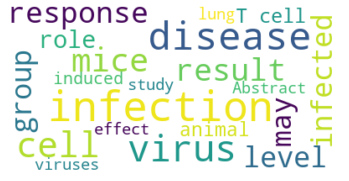

In [12]:
cluster3 = partial_df[partial_df["assigned topic"] == 9]
abstractStrings = cluster3.sample(100)["abstract"].values
wordCloudString = ""
for i in np.arange(100):
    wordCloudString += abstractStrings[i]
    
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(wordCloudString)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [13]:
partial_df.to_csv("document_clusters.csv")